In [1]:
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap#, cm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import os
import sys
import time
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
#import warnings
#warnings.filterwarnings("ignore")

def cm2inch(value):
    return value/2.54

def rot2geo(xin,yin):


    pollon=-170.
    pollat=40.
    xgeo=[i for i in xin]
    ygeo=[i for i in yin]

    for i in range(len(xin)):
        ygeo[i]=180./math.pi * math.asin(math.sin(math.pi/180.*yin[i])*math.sin(math.pi/180.*pollat) + math.cos(math.pi/180.*yin[i])*math.cos(math.pi/180.*xin[i])*math.cos(math.pi/180.*pollat))

        xgeo[i]=180./math.pi * math.atan((math.cos(math.pi/180.*yin[i])*math.sin(math.pi/180.*xin[i]))/(math.sin(math.pi/180.*pollat)*math.cos(math.pi/180.*yin[i])*math.cos(math.pi/180.*xin[i])-math.sin(math.pi/180.*yin[i])*math.cos(math.pi/180.*pollat))) + pollon + 180

    return(xgeo,ygeo)

def meter2grad(meter):
    grad=np.zeros(len(meter))
    for i in range(len(meter)):
        grad[i] = meter[i]/6.3710088e6 * 180./np.pi
    return grad

def grad2meter(grad):
    meter=np.zeros(len(grad))
    for i in range(len(grad)):
        meter[i] = grad[i]*6.3710088e6 * np.pi/180.
    return meter

In [2]:
totaltime=time.time()
print()
print('Start')
print('│')
print('├──read data')
stime=time.time()
files = []
for (dirpath, dirnames, filenames) in os.walk("."):
    files.extend(filenames)


files=sorted(files)
namelist=[]
# datestring=[]
for name in files:
    if name[-3:]=='.nc' and name[:4]=='part':
        namelist.append(name)
        # datestring.append(name[5:-3])

nfile=0
timesave=0
timediff=0
for fn in namelist[:]:
    nfile+=1
    sys.stdout.write('\r'+'│  │ '+fn)
    sys.stdout.flush()
    datestring=fn[5:-3]


    # data input
    f=Dataset(fn,'r')
    intime = f.variables['time'][:]
    inz    = f.variables['z'][:]          # [m]
    inzrel = f.variables['zrel'][:]          # [m]
    inlat  = f.variables['latitude'][:]   # [rotlat]
    inlon  = f.variables['longitude'][:]  # [rotlon]
    insize = f.variables['size'][:]  # [rotlon]
    indt   = f.getncattr('output_time_step_in_sec')
    f.close()


    if nfile == 1:
        #timesave=len(intime)
        timesave=intime[2]
        z=np.asarray(inz)
        zrel=np.asarray(inzrel)
        rlat=np.asarray(inlat)
        rlon=np.asarray(inlon)
        size=np.asarray(insize)
    else:
        #timediff=timesave-len(intime)
        timediff=int((intime[2]-timesave)/indt)
        if timediff != 0:
            dim=inz.shape

            oz    = np.zeros((timediff,dim[1]))
            ozrel = np.zeros((timediff,dim[1]))
            olat  = np.zeros((timediff,dim[1]))
            olon  = np.zeros((timediff,dim[1]))
            
            oz[:,:]   = inz[1][:]
            ozrel[:,:]= inzrel[1][:]
            olat[:,:] = inlat[0][:]
            olon[:,:] = inlon[0][:]
            

            inz[0][:]=inz[1][:]
            inzrel[0][:]=inzrel[1][:]

            inz   = np.concatenate((oz  ,np.asarray(inz)),   axis=0)
            inzrel= np.concatenate((ozrel  ,np.asarray(inzrel)),   axis=0)
            inlat = np.concatenate((olat,np.asarray(inlat)), axis=0)
            inlon = np.concatenate((olon,np.asarray(inlon)), axis=0)

        
        if np.asarray(inz).shape != z.shape:
            if np.asarray(inz).shape[0] > z.shape[0]:
                znew=np.zeros((np.asarray(inz).shape[0],z.shape[1]))
                znew[:z.shape[0],:]=z
                znew[z.shape[0]:,:]=z[-1,:]
                
                zrelnew=np.zeros((np.asarray(inzrel).shape[0],zrel.shape[1]))
                zrelnew[:zrel.shape[0],:]=zrel
                zrelnew[zrel.shape[0]:,:]=zrel[-1,:]

                rlatnew=np.zeros((np.asarray(inlat).shape[0],rlat.shape[1]))
                rlatnew[:z.shape[0],:]=rlat
                rlatnew[z.shape[0]:,:]=rlat[-1,:]

                rlonnew=np.zeros((np.asarray(inlon).shape[0],rlon.shape[1]))
                rlonnew[:rlon.shape[0],:]=rlon
                rlonnew[rlon.shape[0]:,:]=rlon[-1,:]

                z=np.concatenate((znew,np.asarray(inz)), axis=1)
                zrel=np.concatenate((zrelnew,np.asarray(inzrel)), axis=1)
                rlat=np.concatenate((rlatnew,np.asarray(inlat)), axis=1)
                rlon=np.concatenate((rlonnew,np.asarray(inlon)), axis=1)
                
            else:
                inznew=np.zeros((z.shape[0],inz.shape[1]))
                inznew[:inz.shape[0],:]=np.asarray(inz)
                inznew[inz.shape[0]:,:]=np.asarray(inz)[-1,:]
                
                inzrelnew=np.zeros((zrel.shape[0],inzrel.shape[1]))
                inzrelnew[:inzrel.shape[0],:]=np.asarray(inzrel)
                inzrelnew[inzrel.shape[0]:,:]=np.asarray(inzrel)[-1,:]
                
                inlatnew=np.zeros((rlat.shape[0],inlat.shape[1]))
                inlatnew[:inlat.shape[0],:]=np.asarray(inlat)
                inlatnew[inlat.shape[0]:,:]=np.asarray(inlat)[-1,:]
                
                inlonnew=np.zeros((rlon.shape[0],inlon.shape[1]))
                inlonnew[:inlon.shape[0],:]=np.asarray(inlon)
                inlonnew[inlon.shape[0]:,:]=np.asarray(inlon)[-1,:]
 
                z=np.concatenate((z,inznew), axis=1)
                zrel=np.concatenate((zrel,inzrelnew), axis=1)
                rlat=np.concatenate((rlat,inlatnew), axis=1)
                rlon=np.concatenate((rlon,inlonnew), axis=1)

        else:  
            z=np.concatenate((z,np.asarray(inz)), axis=1)
            zrel=np.concatenate((zrel,np.asarray(inzrel)), axis=1)
            rlat=np.concatenate((rlat,np.asarray(inlat)), axis=1)
            rlon=np.concatenate((rlon,np.asarray(inlon)), axis=1)
            
            
        size=np.concatenate((size,np.asarray(insize)), axis=0)
    
    
    print(' -> '+str(int(time.time()-stime))+'s')


print('│  done '+str(int(time.time()-stime))+'s')
print('│')




Start
│
├──read data
│  │ part_2017053111.nc -> 1s
│  │ part_2017053112.nc -> 13s
│  done 13s
│


In [3]:
print('├──find start and end points')
stime=time.time()

dimz=z.shape

                
# list that holds the pure trajetory information,
# without dead spaces before start and after dead of traj
traid=[]
trastart=[]
trastop=[]

idc=-1
first=True
bintop = [0.28,0.30,0.35,0.4,0.45,0.5,0.58,0.65,0.7,0.8,1.,1.3,1.6,2.0,2.5,3.,3.5,4.,5.,6.5,7.5,8.5,10.,12.5,15.,17.5,20.,25.,30.,32.,50.]
bintopscale=[bintop[i]*1.e-6 for i in range(len(bintop))]
bins = [[] for i in range(len(bintop))]
# start with second traj
for id in range(1,dimz[1]):
    idc+=1
    traid.append(id)
 
    # identify startpoint of traj
    if not first:
        pvt=trastart[idc-1]  # previously start time
        
    if not first and z[pvt][id] != z[0][id] and z[pvt][id] != z[1][id] and z[pvt-1][id] == z[1][id]:
        trastart.append(pvt)
    else: 
        for t in range(1,dimz[0]):
            if z[t][id] != z[0][id] and z[t][id] != z[1][id]:
                first=False
                trastart.append(t)
                break
            
    # identify position when the particle is dead
    tstop=0
    btime=trastart[idc] # bottom time
    ttime=dimz[0]-1    # top time
    nloop=0
    while ttime-btime > 10: 
        nloop+=1
        jtime=int((btime+ttime)/2)
        if z[jtime,id] != z[jtime-1,id]: # -> alive
            if z[jtime,id] == z[jtime+1,id]: # -> dead
                tstop=jtime
                break
            else: # -> alive -> increase btime
                btime=jtime
        
        else: # -> dead decrease ttime
            ttime=jtime
    
    #print(nloop,btime,ttime,trastop)
    nloop=0
    if tstop==0:
        for t in range(btime,ttime):
            nloop+=1
            if z[t,id] == z[t+1,id]:
                tstop=t
                break
                
    if tstop==0 and ttime == dimz[0]-1:
        tstop=ttime
        
    if trastart[idc]==tstop:
        trastart[idc]-=1
        
    if tstop > 0:            
        trastop.append(tstop)
        
    
    
    for b in range(len(bins)):
        top = bintop[b] * 1.e-6
        if b == 0:
            bot = 0.
        else:
            bot = bintop[b-1] * 1.e-6

        if size[id] > bot and size[id] <= top:
            bins[b].append(idc)
            break
    

                
#print(tra)
#print()
#print(trastart)

print('│  └─done '+str(int(time.time()-stime))+'s')
print('│')

├──find start and end points
│  └─done 3s
│


In [4]:
print('├──create stat values')
stime=time.time()

# define stat values
st_max_height = np.zeros(len(traid))
st_mean_height = np.zeros(len(traid))
st_distance_2d = np.zeros(len(traid))
st_distance_z = np.zeros(len(traid))
st_depo_z = np.zeros(len(traid))
st_time = np.zeros(len(traid))

st_test = np.zeros(10000)

nid=0
for nid in range(len(traid)):
    i=traid[nid]
    st_max_height[nid] = np.max(z[trastart[nid]:trastop[nid],i])
    st_mean_height[nid] = np.mean(z[trastart[nid]:trastop[nid],i])
    st_depo_z[nid] = z[trastop[nid],i]
    

    
    for t in range(trastart[nid],trastop[nid]):
        x_st = np.abs(rlon[t,i]-rlon[t-1,i])
        y_st = np.abs(rlat[t,i]-rlat[t-1,i])
        z_st = np.abs(z[t,i]-z[t-1,i])
        st_distance_2d[nid]+=np.sqrt(x_st**2+y_st**2)*6.3710088*10**6 * np.pi/180.
        st_distance_z[nid]+=z_st
        st_time[nid]+=indt/60.

    #nid+=1
    
print('│  └─done '+str(int(time.time()-stime))+'s')
print('│')

├──create stat values
│  └─done 179s
│


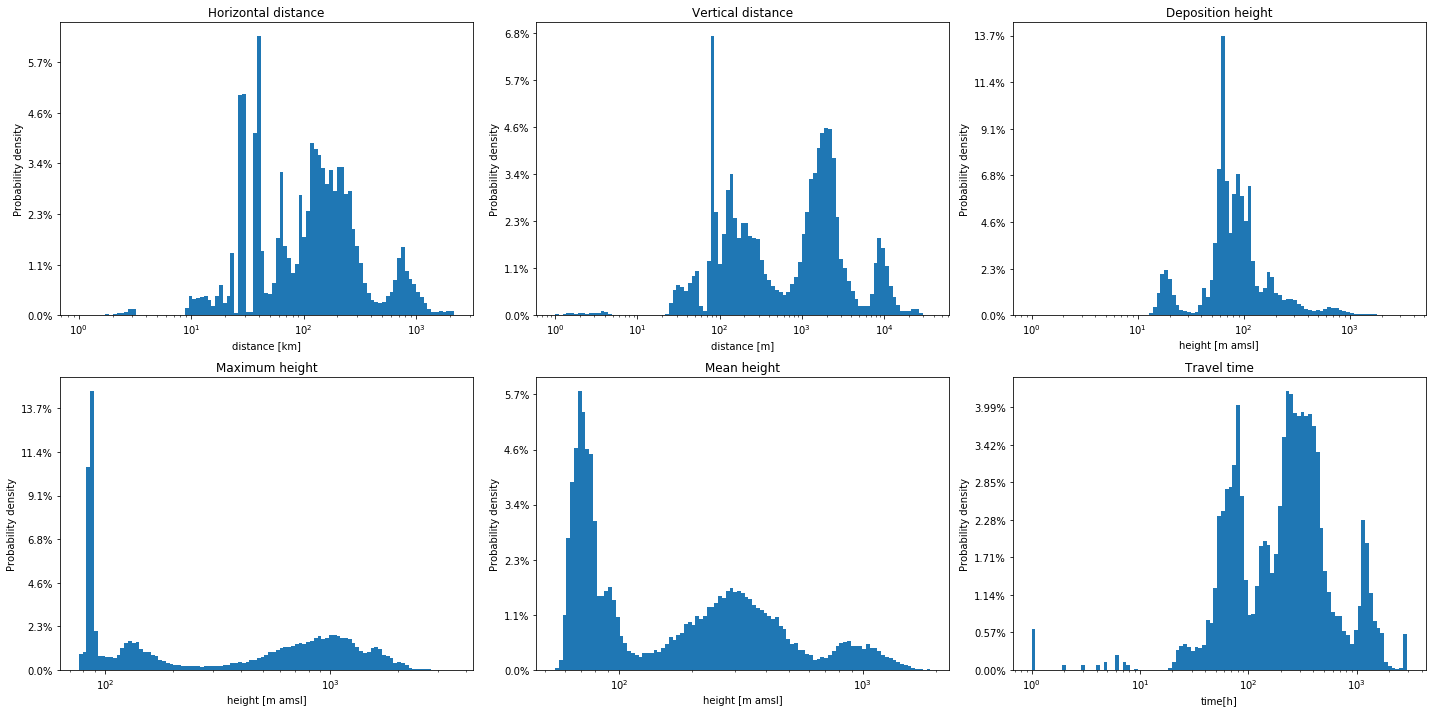

In [5]:
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)



# the histogram of the data

num_bins=100
var_names=  [st_distance_2d/1000  ,st_distance_z      ,st_depo_z          ,st_max_height    ,st_mean_height   ,st_time]
title_names=['Horizontal distance','Vertical distance','Deposition height','Maximum height' ,'Mean height'    ,'Travel time']
x_names=    ['distance [km]'      ,'distance [m]'     ,'height [m amsl]'  ,'height [m amsl]','height [m amsl]','time[h]']

i=0
j=0
for var,title,xname in zip(var_names,title_names,x_names):
    add=0.
    if np.min(var) == 0.:
        add=1.
    logbins=np.logspace(np.log10(np.min(var)+add),np.log10(np.max(var)), num_bins)
    n, bins, patches = ax[j,i].hist(var, bins=logbins)#, density=True)
    numhist=np.histogram(var, num_bins)
    ax[j,i].set_xscale("log")
    #ax[j,i].set_yscale("log")
    ax[j,i].set_title(title)
    #ax[j,i].set_ylim([0,sorted(numhist[0][:])[-2]+len(var)*0.007])
#ax[1,0].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
    ax[j,i].yaxis.set_major_formatter(PercentFormatter(xmax=len(var)))
    ax[j,i].set_ylabel('Probability density')
    ax[j,i].set_xlabel(xname)
#ax[1,0].set_xticks(numhist[1][0::4])
#plt.setp(ax[1,0].xaxis.get_majorticklabels(), rotation=-40)
    i+=1
    if i>2:
        i=0
        j+=1

# mea
import datetime

fname=datetime.datetime.now().strftime("%Y%m%d%H%M")+'.png'
plt.tight_layout()
plt.savefig(fname,dpi=500)
plt.show()